In [1]:
from matplotlib import pyplot as plt
import numpy as np
import open3d 
import pickle
import cv2
import torch
import math

In [2]:
cap = cv2.VideoCapture('http://raspberrypi.local:8088/stream')

In [3]:
ret,img_init = cap.read()

In [4]:
#openCV uses BGR while matplotlib uses RGB
img_init = cv2.cvtColor(img_init, cv2.COLOR_BGR2RGB)

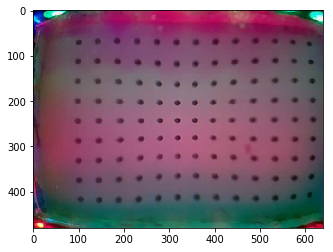

In [5]:
plt.imshow(img_init)

In [6]:
# initialize the device for torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def get_diff_img(img1,img2):
    return np.clip((img1.astype(int) - img2.astype(int)), 0, 255)#.astype(np.uint8)

In [8]:
#Create the denominator for fast poisson 
im_w = img_init.shape[1]
im_h = img_init.shape[0]
f_w = im_w - 2
f_h = im_h - 2

angle = np.pi/4
(x,y) = torch.meshgrid(torch.arange(1,f_w+1), torch.arange(1,f_h+1))
x = x.T.type(torch.float32)
y = y.T.type(torch.float32)

d =  (2*torch.cos(math.pi*x/(f_w+2))-2) + (2*torch.cos(math.pi*y/(f_h+2)) - 2)
denom = (2*torch.cos(math.pi*x/(d.shape[1]+2))-2) + (2*torch.cos(math.pi*y/(d.shape[0]+2)) - 2)
denom = denom.to(device)

In [9]:
def dct(x, norm=None):
    """
    Discrete Cosine Transform, Type II (a.k.a. the DCT)

    For the meaning of the parameter `norm`, see:
    https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.fftpack.dct.html

    :param x: the input signal
    :param norm: the normalization, None or 'ortho'
    :return: the DCT-II of the signal over the last dimension
    """
    x_shape = x.shape
    N = x_shape[-1]
    x = x.contiguous().view(-1, N)

    v = torch.cat([x[:, ::2], x[:, 1::2].flip([1])], dim=1)
    
    
    Vc = torch.view_as_real(torch.fft.fft(v)) 
    #for older versions of PyTorch, use the following line instead of above line
    #Vc = torch.rfft(v, 1, onesided=False)

    k = - torch.arange(N, dtype=x.dtype, device=x.device)[None, :] * np.pi / (2 * N)
    W_r = torch.cos(k)
    W_i = torch.sin(k)

    V = Vc[:, :, 0] * W_r - Vc[:, :, 1] * W_i

    if norm == 'ortho':
        V[:, 0] /= np.sqrt(N) * 2
        V[:, 1:] /= np.sqrt(N / 2) * 2

    V = 2 * V.view(*x_shape)

    return V


def idct(X, norm=None):
    """
    The inverse to DCT-II, which is a scaled Discrete Cosine Transform, Type III

    Our definition of idct is that idct(dct(x)) == x

    For the meaning of the parameter `norm`, see:
    https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.fftpack.dct.html

    :param X: the input signal
    :param norm: the normalization, None or 'ortho'
    :return: the inverse DCT-II of the signal over the last dimension
    """

    x_shape = X.shape
    N = x_shape[-1]

    X_v = X.contiguous().view(-1, x_shape[-1]) / 2

    if norm == 'ortho':
        X_v[:, 0] *= np.sqrt(N) * 2
        X_v[:, 1:] *= np.sqrt(N / 2) * 2

    k = torch.arange(x_shape[-1], dtype=X.dtype, device=X.device)[None, :] * np.pi / (2 * N)
    W_r = torch.cos(k)
    W_i = torch.sin(k)

    V_t_r = X_v
    V_t_i = torch.cat([X_v[:, :1] * 0, -X_v.flip([1])[:, :-1]], dim=1)

    V_r = V_t_r * W_r - V_t_i * W_i
    V_i = V_t_r * W_i + V_t_i * W_r

    V = torch.cat([V_r.unsqueeze(2), V_i.unsqueeze(2)], dim=2)

    
    v = torch.view_as_real(torch.fft.ifft(torch.view_as_complex(V)))[:,:,0]
    #for older versions of PyTorch, use the following line instead of above line
    #v = torch.irfft(V, 1, onesided=False)


    x = v.new_zeros(v.shape)
    x[:, ::2] += v[:, :N - (N // 2)]
    x[:, 1::2] += v.flip([1])[:, :N // 2]

    return x.view(*x_shape)

In [10]:
def poisson_reconstruct(grady, gradx,denom):
    gyy = grady[1:,:-1] - grady[:-1,:-1]
    gxx = gradx[:-1,1:] - gradx[:-1,:-1]
    f = torch.zeros(gradx.shape).to(device)
    f[:-1,1:] += gxx
    f[1:,:-1] += gyy

    f = f[1:-1,1:-1]
    
    tt=dct(f, norm='ortho')
    fsin = dct(tt.T,norm='ortho').T
    f = fsin/denom

    tt=idct(f, norm='ortho')
    img_tt =idct(tt.T,norm='ortho').T
    
    rec = img_tt
    return rec

In [33]:
vis = open3d.visualization.Visualizer()
vis.create_window()
FirstRun=True
pcd = open3d.geometry.PointCloud()
# create the pointcloud and fill array
#we lose 2 rows and cols when calculating gradx and grady
n = img_init.shape[1]-2 
m = img_init.shape[0]-2

x = np.arange(n)
y = np.arange(m)
X, Y = np.meshgrid(x,y)

#points = np.zeros([n * m, 3])
# map it to finger geometry
sensor_length = 0.045
sensor_width = 0.03
X_scl = np.interp(X,(0,(img_init.shape[1]-1)),(0,sensor_length))
Y_scl = np.interp(Y,(0,(img_init.shape[0]-1)),(0,sensor_width))

#points[:, 0] = np.ndarray.flatten(X_scl )
#points[:, 1] = np.ndarray.flatten(Y_scl)
#points[:, 2] = np.ndarray.flatten(np.ones((478, 638))*0.0001)

#points = np.random.rand(100, 3)
#points at the two opposite corners of the visualisation volume
points = np.array([[0,0,0], [0.03,0.03,0.0028]])

pcd.points = open3d.utility.Vector3dVector(points)

vis.add_geometry(pcd)

True

In [34]:
def run_reconstruction():
    global FirstRun
    #global points
    #global X_scl
    #global Y_scl
    
    #get image 
    ret,img = cap.read()
    
    #openCV uses BGR while matplotlib uses RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #get difference image
    diff_img = get_diff_img(img,img_init)
    
    #Create gradient images and do reconstuction
    gradx = torch.as_tensor(diff_img[:,:,1] - diff_img[:,:,0],dtype = torch.float32 ).to(device)
    grady = torch.as_tensor(diff_img[:,:,2], dtype=torch.float32).to(device)
    
    #reconstruct the image, copy to CPU memory and convert to numpy array
    rec_img = poisson_reconstruct(gradx,grady,denom).cpu().numpy()
    #print(rec_img.min(),rec_img.max())
    
    # we can clip the negative values to zero, assuming we are ONLY PUSHING on the elastomer and NO PULLING
    rec_img = rec_img.clip(0)
    
    #scale the value into mm ( NOTE: we assume the deformation is linear over small distanes and obeys Hook's Law )
    # parameters are estimated approximately by trial and error experimentation
    #the deformation of elastomer of 3 mm thickness is assumed to be in the range 0 - 0.0028
    # and at max deformation (2.8mm), the rec_img max value is found to be 2000
    rec_img =  np.interp(rec_img,(0,1500),(0,0.0028))
    
    #if(FirstRun):
    #pcd.clear()
    points = np.zeros([n * m, 3])
    points[:, 0] = np.ndarray.flatten(X_scl )
    points[:, 1] = np.ndarray.flatten(Y_scl)
    points[:, 2] = np.ndarray.flatten(rec_img)


    pcd.points = open3d.utility.Vector3dVector(points)
    
    vis.update_geometry(pcd)
    vis.poll_events()
    vis.update_renderer()

    

In [ ]:
while(True):
    run_reconstruction()

In [32]:
vis.destroy_window()